# Import libraries

In [6]:
import pandas as pd
import spacy
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
import numpy as np
import pickle
from __future__ import print_function
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
nlp = spacy.load("en_core_web_sm")

In [7]:
random_state=695

In [15]:
# a little helper function to load model from pkl file
def load_model(x):
    infile = open(x,'rb')
    lda_model = pickle.load(infile)
    infile.close()
    return lda_model

# Import reviews

In [8]:
with open('sg_reviews.pkl', 'rb') as f:
    sg_reviews = pickle.load(f)
    
with open('au_reviews.pkl', 'rb') as s:
    au_reviews = pickle.load(s)

In [9]:
sg_reviews['review']=sg_reviews['review'].astype(str)
au_reviews['review']=au_reviews['review'].astype(str)

# Pre-processing

In [10]:
stop_words=spacy.lang.en.stop_words.STOP_WORDS
common_phrase=['food panda', 'panda', 'deliveroo', 'doordash', 'ubereats', 'ubereat', 'menulog', 'grubhub', 'grabfood', 'good', 'nice',
              'excellent', 'ok','amazing', 'great']
stop_words.update(common_phrase)

def spacy_tokenizer(tokens):
    
     
    # lemmetize and remove punctuation
    lemma_tokens=[token.lemma_.lower().strip() for token in tokens if not token.is_punct]
    
    # removing stop words
    lemma_tokens_no_stop_words=[word for word in lemma_tokens if word not in stop_words]
    
      
    return lemma_tokens_no_stop_words

def preprocess_pipe(text_col, noun=False):
    preproc_pipe = []
    if noun==False:
        for doc in nlp.pipe(text_col, disable=['parser', 'ner'], n_process=15, batch_size=2000):
            preproc_pipe.append(spacy_tokenizer(doc))
    else:
        for doc in nlp.pipe(text_col, disable=['ner'], n_process=15, batch_size=2000):
            preproc_pipe.append([n.text for n in doc.noun_chunks])
    return preproc_pipe


In [11]:
%%time
print("start preprocessing sg")
sg_reviews['review_tok']=preprocess_pipe(sg_reviews['review'])
print("start preprocessing au")
au_reviews['review_tok']=preprocess_pipe(au_reviews['review'])

print('finish preprocessing')

sg_pos_reviews=sg_reviews[sg_reviews['rating']>2]
sg_neg_reviews=sg_reviews[sg_reviews['rating']<3]
au_pos_reviews=au_reviews[au_reviews['rating']>2]
au_neg_reviews=au_reviews[au_reviews['rating']<3]

all_pos_reviews=pd.concat([sg_pos_reviews, au_pos_reviews], ignore_index=True)
all_neg_reviews=pd.concat([sg_neg_reviews, au_neg_reviews], ignore_index=True)

start preprocessing sg
start preprocessing au
finish preprocessing
CPU times: total: 7min 26s
Wall time: 8min 2s


# Sickit-learn - Model Training

In [12]:
#tfidf vectorization
def dummy(x):
    return x

def vectorization(text, spacy=True, split=True):
    
    if split==True:
        X_train, X_test=train_test_split(text, test_size=0.1, random_state=random_state)
    else:
        X_train=text
        vectorized_data_test=None
    
    if spacy==True:
        tfidf_vectorizer = TfidfVectorizer(ngram_range = (1,1),
                                           min_df=100,
                                           analyzer='word',
                                           tokenizer=dummy,
                                           preprocessor=dummy,
                                           token_pattern=None)        
    else:
        tfidf_vectorizer = TfidfVectorizer(ngram_range = (1,1), lowercase=True, min_df=100, stop_words='english')

    tfidf_documents = tfidf_vectorizer.fit_transform(X_train)
    
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    
    if split==True:
        vectorized_data_test=tfidf_vectorizer.transform(X_test)
    
    return tfidf_documents, tfidf_feature_names, tfidf_vectorizer, vectorized_data_test

In [13]:
def lda_training(n_topic, tfidf_doc, feature_names, test_data=None):

    lda = LatentDirichletAllocation(n_components = n_topic,
                                    learning_method='online',
                                    random_state=random_state,
                                    batch_size=128,
                                    evaluate_every = -1,
                                    n_jobs = 15)
    lda.fit(tfidf_doc)
    topic_models = lda.components_
    if test_data != None:
        # Evaluation Higher the better
        print("Log Likelihood: ", lda.score(test_data))

        # Evaluation Lower the better
        print("Perplexity: ", lda.perplexity(test_data))
    
    #Display top 10 words for each topic
    no_top_words = 10
    
    for topic_idx, topic in enumerate(lda.components_):
        term_list = [feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        print("topic %d:" % (topic_idx), term_list)
    
    return lda

Start with 10% of the data to search the best value for n_components.

In [24]:
%%time
tfidf_documents, feature_names, vectorizer, vectorized_data_test = vectorization(sg_reviews.sample(frac=0.1, random_state=random_state).review_tok, spacy=True)
sg_sklearn_model=lda_training(2, tfidf_documents, feature_names, vectorized_data_test)
pyLDAvis.sklearn.prepare(sg_sklearn_model, tfidf_documents, vectorizer)

Log Likelihood:  -48845.62809345055
Perplexity:  311.2948798805861
topic 0: ['app', 'service', 'food', 'delivery', 'love', 'bad', 'fast', '👍', 'awesome', 'like']
topic 1: ['order', 'easy', 'use', 'time', 'restaurant', 'experience', 'work', 'grab', 'food', 'update']
CPU times: total: 54.5 s
Wall time: 53.3 s


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.312712  0.0       1        1  60.228532
0     -0.312712  0.0       2        1  39.771468, topic_info=          Term         Freq        Total Category  logprob  loglift
30         app  5820.000000  5820.000000  Default  30.0000  30.0000
346    service  2802.000000  2802.000000  Default  29.0000  29.0000
106   delivery  1579.000000  1579.000000  Default  28.0000  28.0000
225       love  1226.000000  1226.000000  Default  27.0000  27.0000
41         bad  1225.000000  1225.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
143        fee   173.074659   173.928517   Topic2  -5.1757   0.9171
106   delivery  1511.035749  1579.834012   Topic2  -3.0089   0.8775
212       like   658.148959   688.273116   Topic2  -3.8400   0.8773
150       food  1511.583096  2041.925001   Topic2  -3.0085   0.6213
151  foodpanda   413.551921   557.422623   Topic2  -4.3046   0.6235

[103 rows x 6 columns], token_table=      Topic      Freq Term
term                      
0         1  0.999565     
0         2  0.003124     
21        1  0.997170  add
21        2  0.003666  add
30        1  0.000172  app
...     ...       ...  ...
443       2  0.999994    👍
446       1  0.004687    😊
446       2  0.998372    😊
447       1  0.004766    😍
447       2  0.996194    😍

[144 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [25]:
%%time
tfidf_documents, feature_names, vectorizer, vectorized_data_test = vectorization(sg_reviews.sample(frac=0.1, random_state=random_state).review_tok, spacy=True)
sg_sklearn_model=lda_training(3, tfidf_documents, feature_names, vectorized_data_test)
pyLDAvis.sklearn.prepare(sg_sklearn_model, tfidf_documents, vectorizer)

Log Likelihood:  -49668.78661512835
Perplexity:  365.53917702542026
topic 0: ['app', 'service', 'bad', '👍', 'experience', 'customer', 'thank', 'cancel', 'wait', 'far']
topic 1: ['food', 'order', 'delivery', 'use', 'easy', 'time', 'fast', 'restaurant', 'foodpanda', 'rider']
topic 2: ['love', 'awesome', 'grab', 'like', 'work', 'convenient', 'driver', 'helpful', 'update', 'need']
CPU times: total: 53.8 s
Wall time: 53 s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.234828  0.296338       1        1  38.085479
0     -0.142618 -0.348880       2        1  31.109766
2      0.377446  0.052542       3        1  30.804755, topic_info=         Term         Freq        Total Category  logprob  loglift
33        app  5558.000000  5558.000000  Default  30.0000  30.0000
337   service  2765.000000  2765.000000  Default  29.0000  29.0000
149      food  1913.000000  1913.000000  Default  28.0000  28.0000
223      love  1187.000000  1187.000000  Default  27.0000  27.0000
105  delivery  1414.000000  1414.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
359    superb   179.819975   180.491391   Topic3  -4.8693   1.1738
77       code   190.060051   190.773643   Topic3  -4.8139   1.1738
274     phone   179.655537   180.367402   Topic3  -4.8702   1.1735
386         u   204.616691   210.844870   Topic3  -4.7401   1.1475
254        nt   230.047536   461.619679   Topic3  -4.6229   0.4810

[134 rows x 6 columns], token_table=      Topic      Freq Term
term                      
0         1  0.003270     
0         2  0.994123     
0         3  0.003270     
2         1  0.987299    1
2         2  0.004816    1
...     ...       ...  ...
422       3  0.997337    ️
424       3  0.997982    👌
425       2  0.999134    👍
428       2  0.995126    😊
429       3  0.997457    😍

[125 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

In [26]:
%%time
tfidf_documents, feature_names, vectorizer, vectorized_data_test = vectorization(sg_reviews.sample(frac=0.1, random_state=random_state).review_tok, spacy=True)
sg_sklearn_model=lda_training(4, tfidf_documents, feature_names, vectorized_data_test)
pyLDAvis.sklearn.prepare(sg_sklearn_model, tfidf_documents, vectorizer)

Log Likelihood:  -51333.34646146286
Perplexity:  445.4777733374629
topic 0: ['app', 'order', '👍', 'experience', 'restaurant', 'foodpanda', 'deliver', 'cancel', 'discount', 'wait']
topic 1: ['food', 'delivery', 'use', 'easy', 'fast', 'time', 'work', 'rider', 'order', 'app']
topic 2: ['love', 'bad', 'awesome', 'grab', 'like', 'convenient', 'helpful', 'update', 'thank', 'need']
topic 3: ['service', 'nt', 'poor', 'customer', 'super', '❤', '️', '😊', '👌', 'promo']
CPU times: total: 55.6 s
Wall time: 54.6 s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.173839  0.055599       1        1  31.827959
2      0.008148 -0.399069       2        1  26.656947
1     -0.233592  0.196287       3        1  24.276861
3      0.399284  0.147183       4        1  17.238232, topic_info=          Term         Freq        Total Category  logprob  loglift
337    service  3450.000000  3450.000000  Default  30.0000  30.0000
33         app  5112.000000  5112.000000  Default  29.0000  29.0000
149       food  1995.000000  1995.000000  Default  28.0000  28.0000
105   delivery  1491.000000  1491.000000  Default  27.0000  27.0000
396        use  1465.000000  1465.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
412  wonderful   126.805324   127.532978   Topic4  -4.6380   1.7523
265    overall   129.733367   130.480556   Topic4  -4.6152   1.7523
217        log   127.794417   128.552635   Topic4  -4.6303   1.7521
254         nt   558.339483   562.117880   Topic4  -3.1557   1.7513
93    customer   319.023522   605.823451   Topic4  -3.7154   1.1167

[172 rows x 6 columns], token_table=      Topic      Freq Term
term                      
0         1  0.973298     
0         2  0.025141     
2         1  0.998132    1
5         1  0.993949    2
7         3  0.994088    3
...     ...       ...  ...
422       4  0.997102    ️
424       4  0.995375    👌
425       1  0.998430    👍
428       4  0.997740    😊
429       2  0.994630    😍

[156 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4])

In [27]:
%%time
tfidf_documents, feature_names, vectorizer, vectorized_data_test = vectorization(sg_reviews.sample(frac=0.1, random_state=random_state).review_tok, spacy=True)
sg_sklearn_model=lda_training(5, tfidf_documents, feature_names, vectorized_data_test)
pyLDAvis.sklearn.prepare(sg_sklearn_model, tfidf_documents, vectorizer)

Log Likelihood:  -52149.995844128374
Perplexity:  490.86893900225056
topic 0: ['app', '👍', 'experience', 'restaurant', 'foodpanda', 'option', 'discount', 'far', 'voucher', 'hour']
topic 1: ['easy', 'food', 'use', 'delivery', 'fast', 'time', 'app', 'useful', 'driver', 'order']
topic 2: ['love', 'bad', 'grab', 'app', 'work', 'like', 'convenient', 'helpful', 'thank', 'friendly']
topic 3: ['service', 'application', 'super', '😊', '👌', 'n', 'area', 'na', 'wow', 'happy']
topic 4: ['order', 'awesome', 'time', 'food', 'deliver', 'cancel', 'delivery', 'customer', 'nt', 'payment']
CPU times: total: 54.5 s
Wall time: 54 s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.139881  0.241348       1        1  30.581683
0      0.091572 -0.199220       2        1  21.056185
1      0.186325  0.171505       3        1  18.572813
2      0.023494 -0.304977       4        1  16.776418
3     -0.441271  0.091344       5        1  13.012901, topic_info=        Term         Freq        Total Category  logprob  loglift
337  service  3581.000000  3581.000000  Default  30.0000  30.0000
33       app  5371.000000  5371.000000  Default  29.0000  29.0000
119     easy  1433.000000  1433.000000  Default  28.0000  28.0000
223     love  1221.000000  1221.000000  Default  27.0000  27.0000
396      use  1425.000000  1425.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
200       ko   117.412149   118.198745   Topic5  -4.4338   2.0326
141  feature   114.025962   114.825633   Topic5  -4.4631   2.0322
9          4   108.998140   109.803801   Topic5  -4.5082   2.0319
116        e    99.561054   100.352052   Topic5  -4.5987   2.0313
182  improve   150.792855   199.284166   Topic5  -4.1836   1.7604

[213 rows x 6 columns], token_table=      Topic      Freq Term
term                      
0         1  0.995476     
2         2  0.489553    1
2         3  0.508565    1
5         2  0.761470    2
5         3  0.234667    2
...     ...       ...  ...
424       5  0.995877    👌
425       2  0.999257    👍
427       5  0.991356    😁
428       5  0.998097    😊
429       4  0.996914    😍

[197 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 2, 3, 4])

In [28]:
%%time
tfidf_documents, feature_names, vectorizer, vectorized_data_test = vectorization(sg_reviews.sample(frac=0.1, random_state=random_state).review_tok, spacy=True)
sg_sklearn_model=lda_training(6, tfidf_documents, feature_names, vectorized_data_test)
pyLDAvis.sklearn.prepare(sg_sklearn_model, tfidf_documents, vectorizer)

Log Likelihood:  -52937.2271590854
Perplexity:  538.9979044018891
topic 0: ['app', 'restaurant', 'option', 'far', 'voucher', 'hour', 'place', 'add', 'order', 'address']
topic 1: ['easy', 'use', 'fast', 'delivery', 'app', 'useful', 'time', 'food', 'discount', 'application']
topic 2: ['bad', 'food', 'work', 'app', 'helpful', 'update', 'friendly', 'user', 'location', 'need']
topic 3: ['service', 'awesome', 'convenient', 'slow', 'super', '😊', 'n', '😍', 'wow', 'poor']
topic 4: ['order', 'food', 'experience', 'like', 'time', 'customer', 'delivery', 'cancel', 'deliver', 'service']
topic 5: ['love', '👍', 'thank', 'grab', 'foodpanda', 'job', 'app', 'way', '️', 'driver']
CPU times: total: 55.3 s
Wall time: 54.4 s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.009981 -0.139799       1        1  28.647259
0     -0.185466 -0.014332       2        1  20.269937
1     -0.154768 -0.162440       3        1  14.011111
2     -0.146210  0.006272       4        1  13.644572
5      0.045168  0.412603       5        1  11.722459
3      0.431295 -0.102303       6        1  11.704662, topic_info=          Term         Freq        Total Category  logprob  loglift
337    service  3101.000000  3101.000000  Default  30.0000  30.0000
33         app  5327.000000  5327.000000  Default  29.0000  29.0000
119       easy  1498.000000  1498.000000  Default  28.0000  28.0000
223       love  1365.000000  1365.000000  Default  27.0000  27.0000
42     awesome   997.000000   997.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
337    service  2779.039181  3101.025164   Topic6  -1.1637   2.0356
284       poor   205.029260   277.470050   Topic6  -3.7704   1.8426
169       help   176.611248   312.959879   Topic6  -3.9196   1.5731
318       ride    92.800517   148.420107   Topic6  -4.5631   1.6756
305  recommend    84.852315   157.052926   Topic6  -4.6526   1.5295

[262 rows x 6 columns], token_table=      Topic      Freq Term
term                      
0         1  0.997585     
2         1  0.993195    1
5         2  0.863785    2
5         5  0.136644    2
11        1  0.993293    5
...     ...       ...  ...
424       3  0.993897    👌
425       5  0.998648    👍
427       6  0.995721    😁
428       6  0.996741    😊
429       6  0.996584    😍

[256 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 2, 3, 6, 4])

In [29]:
%%time
tfidf_documents, feature_names, vectorizer, vectorized_data_test = vectorization(sg_reviews.sample(frac=0.1, random_state=random_state).review_tok, spacy=True)
sg_sklearn_model=lda_training(7, tfidf_documents, feature_names, vectorized_data_test)
pyLDAvis.sklearn.prepare(sg_sklearn_model, tfidf_documents, vectorizer)

Log Likelihood:  -54068.990420628805
Perplexity:  616.5760059480497
topic 0: ['app', 'convenient', 'like', 'voucher', 'super', 'na', 'cool', 'open', 'perfect', 'support']
topic 1: ['easy', 'use', 'food', 'delivery', 'fast', 'app', 'useful', 'option', 'order', 'add']
topic 2: ['love', 'thank', 'work', 'grab', 'app', 'friendly', 'user', 'application', 'poor', '️']
topic 3: ['helpful', 'nt', 'discount', 'n', 'area', '😍', 'wow', 'expensive', 'deliver', 'ride']
topic 4: ['time', 'awesome', 'order', 'app', 'update', 'delivery', 'restaurant', 'food', 'need', 'use']
topic 5: ['bad', 'experience', 'order', 'foodpanda', 'driver', 'customer', 'cancel', 'food', 'refund', 'price']
topic 6: ['service', '👍', 'far', 'job', '❤', '👌', 'happy', 'life', 'high', 'rate']
CPU times: total: 55.9 s
Wall time: 55.3 s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.151687 -0.164178       1        1  25.803043
1     -0.211164 -0.056384       2        1  16.247596
5     -0.060359 -0.241236       3        1  15.751453
0     -0.085293  0.320471       4        1  12.154538
2     -0.104566  0.169456       5        1  12.139123
6      0.297356 -0.139621       6        1   9.345483
3      0.315712  0.111492       7        1   8.558763, topic_info=        Term         Freq        Total Category  logprob  loglift
33       app  5459.000000  5459.000000  Default  30.0000  30.0000
337  service  3297.000000  3297.000000  Default  29.0000  29.0000
223     love  1238.000000  1238.000000  Default  28.0000  28.0000
119     easy  1314.000000  1314.000000  Default  27.0000  27.0000
425        👍  1004.000000  1004.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
336    serve    76.664746    77.532265   Topic7  -4.4411   2.4470
343    small    71.566101    72.434259   Topic7  -4.5099   2.4462
94         d    70.633317    71.501129   Topic7  -4.5230   2.4460
295  provide   117.060522   171.883397   Topic7  -4.0178   2.0741
104  deliver   234.274690   517.764971   Topic7  -3.3240   1.6652

[304 rows x 6 columns], token_table=      Topic      Freq Term
term                      
0         1  0.998062     
3         3  0.985468   10
4         3  0.964716   15
5         1  0.398226    2
5         3  0.594881    2
...     ...       ...  ...
425       6  0.999325    👍
426       4  0.992684    👎
427       3  0.991366    😁
428       3  0.993934    😊
429       7  0.997670    😍

[302 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 6, 1, 3, 7, 4])

In [30]:
%%time
tfidf_documents, feature_names, vectorizer, vectorized_data_test = vectorization(sg_reviews.sample(frac=0.1, random_state=random_state).review_tok, spacy=True)
sg_sklearn_model=lda_training(8, tfidf_documents, feature_names, vectorized_data_test)
pyLDAvis.sklearn.prepare(sg_sklearn_model, tfidf_documents, vectorizer)

Log Likelihood:  -55179.262850968225
Perplexity:  703.5212600453037
topic 0: ['app', 'fast', 'bad', 'delivery', 'friendly', 'user', 'far', 'add', 'free', 'cool']
topic 1: ['easy', 'food', 'use', 'awesome', 'experience', 'app', 'useful', 'payment', 'order', 'option']
topic 2: ['order', 'time', 'food', 'like', 'convenient', 'restaurant', 'cancel', 'app', 'deliver', 'update']
topic 3: ['helpful', 'grab', 'discount', '', 'driver', '😊', 'n', '😍', 'happy', 'expensive']
topic 4: ['application', 'app', 'slow', 'late', '❤', 'try', 'money', 'nt', 'number', 'account']
topic 5: ['love', '👍', 'work', 'thank', 'job', 'app', '️', 'fee', 'available', 'food']
topic 6: ['service', 'customer', 'address', 'lot', 'na', 'wow', 'improve', 'know', 'choice', '1']
topic 7: ['foodpanda', 'rider', 'poor', 'nt', 'price', 'reliable', '👌', 'promo', 'area', 'life']
CPU times: total: 55.5 s
Wall time: 55.2 s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.082992  0.073049       1        1  22.482855
1      0.182734  0.002058       2        1  15.278114
4     -0.068474 -0.112927       3        1  12.403525
0      0.239949 -0.035621       4        1  11.471434
6     -0.117679  0.085681       5        1  11.296818
7     -0.273626 -0.317955       6        1   9.288360
3     -0.237116  0.329183       7        1   9.184660
5      0.191219 -0.023468       8        1   8.594234, topic_info=        Term         Freq        Total Category  logprob  loglift
33       app  5263.000000  5263.000000  Default  30.0000  30.0000
337  service  2863.000000  2863.000000  Default  29.0000  29.0000
223     love  1380.000000  1380.000000  Default  28.0000  28.0000
425        👍   992.000000   992.000000  Default  27.0000  27.0000
119     easy  1263.000000  1263.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
174   highly     0.151358    51.971741   Topic8 -10.6727  -3.3847
421        ❤     0.151222   242.686912   Topic8 -10.6736  -4.9267
423        🏻     0.151064    81.617302   Topic8 -10.6747  -3.8380
53     bring     0.151055    47.067058   Topic8 -10.6747  -3.2876
161      guy     0.151048   119.150717   Topic8 -10.6748  -4.2165

[343 rows x 6 columns], token_table=      Topic      Freq Term
term                      
0         7  0.997663     
2         3  0.315693    1
2         5  0.680297    1
3         2  0.986614   10
5         3  0.341804    2
...     ...       ...  ...
425       8  0.999345    👍
427       7  0.988644    😁
428       7  0.996970    😊
429       7  0.998313    😍
430       3  0.988513    😡

[349 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 5, 1, 7, 8, 4, 6])

In [31]:
%%time
tfidf_documents, feature_names, vectorizer, vectorized_data_test = vectorization(sg_reviews.sample(frac=0.1, random_state=random_state).review_tok, spacy=True)
sg_sklearn_model=lda_training(9, tfidf_documents, feature_names, vectorized_data_test)
pyLDAvis.sklearn.prepare(sg_sklearn_model, tfidf_documents, vectorizer)

Log Likelihood:  -55441.82454118931
Perplexity:  725.8143311538231
topic 0: ['experience', 'restaurant', 'food', 'order', 'deliver', 'app', 'time', 'hour', 'add', 'delivery']
topic 1: ['easy', 'use', 'food', 'delivery', 'app', 'fast', 'useful', 'option', 'order', 'offer']
topic 2: ['convenient', 'helpful', 'like', 'update', 'grab', 'discount', 'app', 'need', 'location', 'fix']
topic 3: ['service', 'price', 'driver', '😊', 'n', 'superb', 'expensive', 'fee', 'improve', 'help']
topic 4: ['time', 'nt', 'foodpanda', 'order', 'far', 'use', 'application', 'app', 'try', 'charge']
topic 5: ['love', 'awesome', '👍', 'thank', 'work', 'friendly', 'app', 'user', 'job', '️']
topic 6: ['app', 'slow', '❤', '👌', 'cool', 'wow', 'happy', 'useless', 'search', 'fine']
topic 7: ['fast', 'reliable', 'poor', 'gud', 'company', 'satisfied', 'hungry', 'book', 'log', 'sangat']
topic 8: ['bad', 'order', 'cancel', 'rider', 'customer', '', 'payment', 'late', 'service', 'food']
CPU times: total: 56.6 s
Wall time: 56 s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.147227  0.182765       1        1  16.989282
4      0.148276  0.092206       2        1  15.259828
8      0.240986  0.089806       3        1  14.299673
1      0.061226  0.127832       4        1  12.320906
5     -0.243756  0.102680       5        1   8.760655
3      0.103330 -0.268047       6        1   8.630909
2     -0.193598 -0.065441       7        1   8.295707
6     -0.295368  0.066346       8        1   8.293409
7      0.031677 -0.328147       9        1   7.149632, topic_info=        Term         Freq        Total Category  logprob  loglift
33       app  5672.000000  5672.000000  Default  30.0000  30.0000
337  service  2945.000000  2945.000000  Default  29.0000  29.0000
223     love  1186.000000  1186.000000  Default  28.0000  28.0000
119     easy  1314.000000  1314.000000  Default  27.0000  27.0000
42   awesome   901.000000   901.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
284     poor   277.847268   329.703535   Topic9  -2.9735   2.4670
181   hungry   146.851600   163.163477   Topic9  -3.6112   2.5328
139     fast   571.715087   984.566245   Topic9  -2.2520   2.0945
225        m   106.237121   157.740698   Topic9  -3.9349   2.2428
229      map    86.560885   140.135628   Topic9  -4.1398   2.1563

[399 rows x 6 columns], token_table=      Topic      Freq Term
term                      
0         3  0.995339     
1         3  0.388875    $
1         7  0.593546    $
2         1  0.814016    1
2         2  0.143349    1
...     ...       ...  ...
425       5  0.998464    👍
426       9  0.990245    👎
427       6  0.994608    😁
428       6  0.994343    😊
429       5  0.997962    😍

[439 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 9, 2, 6, 4, 3, 7, 8])

In [32]:
%%time
tfidf_documents, feature_names, vectorizer, vectorized_data_test = vectorization(sg_reviews.sample(frac=0.1, random_state=random_state).review_tok, spacy=True)
sg_sklearn_model=lda_training(10, tfidf_documents, feature_names, vectorized_data_test)
pyLDAvis.sklearn.prepare(sg_sklearn_model, tfidf_documents, vectorizer)

Log Likelihood:  -56936.83348742516
Perplexity:  866.899473811719
topic 0: ['app', 'order', 'far', 'hour', 'add', 'wait', 'cancel', 'offer', 'deliver', 'lot']
topic 1: ['easy', 'use', 'fast', 'convenient', 'helpful', 'foodpanda', 'rider', 'slow', 'n', 'poor']
topic 2: ['awesome', 'like', 'app', 'grab', 'order', 'thank', 'friendly', 'user', 'food', 'payment']
topic 3: ['help', 'customer', '', 'address', '😍', 'nt', 'expensive', 'try', 'company', 'hungry']
topic 4: ['experience', 'work', 'time', 'update', 'voucher', 'app', 'need', 'restaurant', 'superb', 'fee']
topic 5: ['love', '👍', 'bad', 'job', 'app', '️', '😊', 'u', 'terbaik', 'di']
topic 6: ['late', 'reliable', 'error', 'wow', 'happy', 'quality', 'gud', 'bug', 'fine', 'stupid']
topic 7: ['driver', 'charge', '❤', '👌', 'promo', 'number', 'option', 'support', 'code', 'phone']
topic 8: ['service', 'improve', 's', 'feature', 'bagus', 'improvement', 'mobile', 'need', '4', 'edit']
topic 9: ['food', 'delivery', 'order', 'app', 'useful', 'disc

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.145051 -0.055757       1        1  18.061998
0      0.209328  0.001862       2        1  14.621608
9      0.212443 -0.046173       3        1  11.198311
7      0.115127  0.008032       4        1  10.190069
1     -0.074004  0.203773       5        1   9.411020
4      0.147035 -0.051945       6        1   9.174871
5      0.009329  0.079099       7        1   7.902517
3     -0.224502 -0.232061       8        1   7.480593
6     -0.247592  0.306791       9        1   6.082557
8     -0.292214 -0.213621      10        1   5.876455, topic_info=          Term         Freq        Total Category  logprob  loglift
337    service  3726.000000  3726.000000  Default  30.0000  30.0000
33         app  4911.000000  4911.000000  Default  29.0000  29.0000
119       easy  1385.000000  1385.000000  Default  28.0000  28.0000
223       love  1205.000000  1205.000000  Default  27.0000  27.0000
425          👍   867.000000   867.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
371      thank     0.137151   452.111133  Topic10 -10.3912  -5.2664
300     rating     0.137150    51.373236  Topic10 -10.3912  -3.0916
199       know     0.137150   143.665117  Topic10 -10.3912  -4.1199
150  foodpanda     0.137150   541.915061  Topic10 -10.3912  -5.4476
319      rider     0.137150   481.789841  Topic10 -10.3912  -5.3300

[432 rows x 6 columns], token_table=      Topic      Freq Term
term                      
0         6  0.149988     
0         8  0.846363     
1         6  0.983174    $
2         1  0.170255    1
2         2  0.823812    1
...     ...       ...  ...
426       7  0.987082    👎
427       7  0.990589    😁
428       7  0.994367    😊
429       8  0.996550    😍
430       9  0.986656    😡

[479 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 10, 8, 2, 5, 6, 4, 7, 9])

The best parameter for n_component looks like is 8 for singgapore dataset! lets train the LDA model using the full dataset. Since this training process will take more than 30 mins, we are loading the trained model in below, but the code is there is you want to reproduce the result

In [60]:
%%time
tfidf_documents, feature_names, vectorizer, vectorized_data_test = vectorization(sg_reviews.review_tok, spacy=True, split=False)
#best_sg_sklearn_model=lda_training(8, tfidf_documents, feature_names, vectorized_data_test)
pyLDAvis.sklearn.prepare(load_model('best_sg_sklearn_model.pkl'), tfidf_documents, vectorizer)

CPU times: total: 4.14 s
Wall time: 10.4 s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.228387 -0.013169       1        1  24.352743
1      0.253327  0.111585       2        1  18.403824
3      0.209279 -0.089118       3        1  12.452681
2     -0.065742 -0.364528       4        1  10.882841
6     -0.106883  0.214144       5        1  10.368291
7     -0.216888  0.059523       6        1   9.126922
5     -0.204951 -0.120795       7        1   7.230307
4     -0.096529  0.202358       8        1   7.182391, topic_info=         Term          Freq         Total Category  logprob  loglift
193       app  46323.000000  46323.000000  Default  30.0000  30.0000
2126  service  28251.000000  28251.000000  Default  29.0000  29.0000
747      easy  15479.000000  15479.000000  Default  28.0000  28.0000
252   awesome  11838.000000  11838.000000  Default  27.0000  27.0000
267       bad  12229.000000  12229.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
2490  useless   1175.124569   1785.226969   Topic8  -4.1071   2.2154
1642     open   1211.837379   2160.841443   Topic8  -4.0764   2.0552
1028     hate    701.969927    907.241436   Topic8  -4.6224   2.3770
1839  problem   1228.326031   2869.784210   Topic8  -4.0629   1.7850
193       app   1643.347315  46323.586702   Topic8  -3.7718  -0.7054

[386 rows x 6 columns], token_table=      Topic      Freq Term
term                      
0         1  0.999686     
5         1  0.838440    1
5         2  0.061894    1
5         8  0.098903    1
25        1  0.859122    2
...     ...       ...  ...
2707      8  0.998413    😠
2715      7  0.996504    😭
2716      4  0.997052    🙂
2724      7  0.996841    🤩
2727      4  0.996807    🥰

[476 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3, 7, 8, 6, 5])

In [45]:
# print out the top 5 reviews that belong to each topic, to have a better understanding on the context
sg_tfidf_documents, sg_feature_names=vectorization(sg_reviews.review_tok, spacy=True, split=False)[:2]

sg_doc_topic=best_sg_sklearn_model.transform(sg_tfidf_documents)
sg_topic_weights=pd.DataFrame(sg_doc_topic, columns=["topic_{}".format(n) for n in range(8)])
sg_topic_weights['review']=sg_reviews.reset_index().review

for n in range(8):
    topic = best_sg_sklearn_model.components_[n]
    term_list = [sg_feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]
    print("topic_{}:".format(n), term_list)
    for review in sg_topic_weights.sort_values('topic_{}'.format(n), ascending=False).head().review.to_list():
        print(review)
        print('-----------------------------')
    print('')

topic_0: ['order', 'food', 'time', 'helpful', 'service', 'customer', 'delivery', 'deliver', 'app', 'driver']
I used grab app many years, this experience really make me fed up..ordered dinner to celebrate Xmas at home, waiting for long time and the food went missing...contacted help center and they say will investigate this issue. However, waiting for two weeks and yet to get any updates. I send email to ask for update few times and not even get any reply. Until I give up I email say if your side couldn’t give any update then please refund me..
Funniest thing is..I got my refund and the status become problem solved. So what means the investigation? I happily ordered food for celebration ended up I received nothing, and this is what grab provided the service?
-----------------------------
Forget about using grab for food delivery when you need it the most - during busy periods or when it rains. Orders placed are stuck at the stage where “it is being accepted” with zero visibility on whet

Aplikasi yang sangat buruk. Saat buka aplikasi, diminta untuk update, lalu saya pun memperbaruinya, tapi lalu muncul tulisan "tidak dpt menginstal", saya pun coba mendownload lagi dan hasilnya sama, tdk dpt menginstal. Padahal internal memori saya masih sangat lega. Ada apa ini ? Apakah Grab hanya ingin mendapatkan keuntungan dari pendownloadan aplikasi yang berkali-kali ?
-----------------------------
Saya cuma bisa kasih bintang 3, itu juga semua untuk orderan makanan atau minuman saja, kalo untuk transportasi, saya kecewa karena Hrus menggunakan facial recognition, saya sdh mencoba berulang kali namun tidak bisa, jadi kecewa banget dengan grab, padahal dulu sebelum diupgrade kalo saya keluar negeri cth mlaysia, saya selalu menggunakan grab
-----------------------------
Lokasi driver tidak tersedia lagi sebelum driver klik 'antar makanan', jadi kalau driver keluyuran pun tidak ketahuan, padahal sebelumnya lokasi driver sudah diperlihatkan langsung saat menerima orderan, jadi darimana

Assign themes to each topic

topic 0: Order placing

topic 1: app UI/functions

topic 2: Delivery in general

topic 3: Service reliability

topic 4: Unclassified

topic 5: Customer service

topic 6: app UI/functions

topic 7: Delivery speed

In [46]:
# calculate the dominant topic for each review
def topic_labeling(row, topic_columns):
    w_dict={}
    for n in topic_columns:
        w_dict[n]=row[n]
    max_key = max(w_dict, key=w_dict.get)
    return max_key
        
    
sg_topic_weights['dominant_topic_label']=sg_topic_weights.apply(lambda row: topic_labeling(row, sg_topic_weights.columns[:-1]), axis=1)

In [47]:
sg_topic_weights['dominant_topic_label']=sg_topic_weights['dominant_topic_label'].replace({'topic_0': 'Order placing',
                                                                                              'topic_1': 'app UI/functions',
                                                                                              'topic_2': 'General feeling on the services',
                                                                                              'topic_3': 'Service reliability',
                                                                                              'topic_4': 'Unclassified',
                                                                                              'topic_5': 'Customer service',
                                                                                              'topic_6': 'app UI/functions',
                                                                                              'topic_7': 'Delivery speed'})

c:\users\stanley\appdata\local\programs\python\python39\lib\site-packages\pandas\plotting\_matplotlib\core.py:1437: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.tick_pos = ax.convert_yunits(self.ax_index).astype(np.int)


<AxesSubplot:title={'center':'Singapore reviews themes'}>

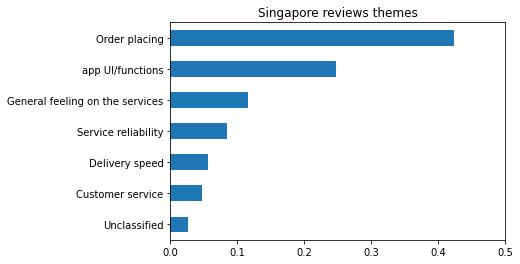

In [48]:
sg_topic_weights['dominant_topic_label'].value_counts(normalize=True, ascending=True).plot.barh(title='Singapore reviews themes', xlim=(0,0.5))

Each review may have more than 1 topic, in here we used the topic contribution score average as a threshold. If a review that has a topic score higher than the topic socre mean, we will assign that topic to the review as well

  0%|          | 0/8 [00:00<?, ?it/s]

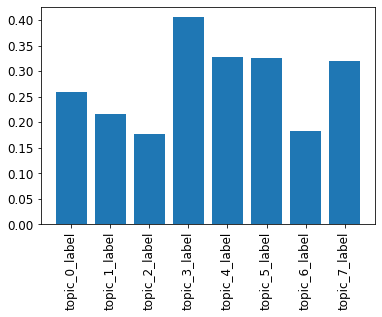

In [61]:
# 
def multiple_labeling(row, col, mean_value):
    if row['dominant_topic_label']==col:
        return True
    elif row[col]>mean_value:
        return True
    else:
        return False
    

for col in tqdm(sg_topic_weights.columns[:8]):
    mean_value=sg_topic_weights[col].mean()
    sg_topic_weights['{}_label'.format(col)]=sg_topic_weights.apply(lambda row: multiple_labeling(row, col, mean_value), axis=1)

y_values=[]
total=sg_topic_weights.shape[0]
for col in sg_topic_weights.columns[-8:]:
    y_values.append(sg_topic_weights[col].value_counts().loc[True]/total)
plt.bar(sg_topic_weights.columns[-8:], y_values)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12 )
plt.show()

# AU reviews
### topic num search

In [35]:
%%time
tfidf_documents, feature_names, vectorizer, vectorized_data_test = vectorization(au_reviews.sample(frac=0.1, random_state=random_state).review_tok, spacy=True)
au_sklearn_model=lda_training(2, tfidf_documents, feature_names, vectorized_data_test)
pyLDAvis.sklearn.prepare(au_sklearn_model, tfidf_documents, vectorizer)

Log Likelihood:  -70050.82599187011
Perplexity:  438.4530469076943
topic 0: ['app', 'use', 'easy', 'order', 'uber', 'bad', 'eat', 'fast', 'experience', 'customer']
topic 1: ['service', 'food', 'love', 'delivery', 'time', 'driver', 'awesome', 'order', 'work', 'deliver']
CPU times: total: 53.6 s
Wall time: 53.8 s


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.278377  0.0       1        1  51.856526
1     -0.278377  0.0       2        1  48.143474, topic_info=           Term         Freq        Total Category  logprob  loglift
40          app  4126.000000  4126.000000  Default  30.0000  30.0000
469     service  2881.000000  2881.000000  Default  29.0000  29.0000
217        food  2345.000000  2345.000000  Default  28.0000  28.0000
550         use  1998.000000  1998.000000  Default  27.0000  27.0000
172        easy  1891.000000  1891.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
571        work   860.372976  1041.847539   Topic2  -4.0604   0.5396
522        time  1060.999710  1648.606806   Topic2  -3.8508   0.2903
565         way   379.769110   467.538276   Topic2  -4.8782   0.5231
361       order   877.482531  2492.969389   Topic2  -4.0407  -0.3132
441  restaurant   444.276029   859.310440   Topic2  -4.7213   0.0713

[122 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
1         1  0.003009     $
1         2  0.998934     $
9         1  0.012942     2
9         2  0.986848     2
17        1  0.004254     5
...     ...       ...   ...
571       2  0.825457  work
583       1  0.004228     👌
583       2  0.997898     👌
584       1  0.002125     👍
584       2  0.998843     👍

[178 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [36]:
%%time
tfidf_documents, feature_names, vectorizer, vectorized_data_test = vectorization(au_reviews.sample(frac=0.1, random_state=random_state).review_tok, spacy=True)
au_sklearn_model=lda_training(3, tfidf_documents, feature_names, vectorized_data_test)
pyLDAvis.sklearn.prepare(au_sklearn_model, tfidf_documents, vectorizer)

Log Likelihood:  -72261.50042519931
Perplexity:  531.2479853986255
topic 0: ['use', 'easy', 'bad', 'app', 'customer', 'uber', 'order', 'option', 'far', 'nt']
topic 1: ['order', 'love', 'food', 'time', 'driver', 'awesome', 'deliver', 'cancel', 'delivery', 'uber']
topic 2: ['app', 'service', 'delivery', 'food', 'work', 'fast', 'convenient', 'experience', 'quick', 'like']
CPU times: total: 54.3 s
Wall time: 54.2 s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.152968  0.279458       1        1  40.390818
0     -0.208803 -0.252111       2        1  35.652547
2      0.361771 -0.027347       3        1  23.956635, topic_info=         Term         Freq        Total Category  logprob  loglift
40        app  4492.000000  4492.000000  Default  30.0000  30.0000
469   service  3145.000000  3145.000000  Default  29.0000  29.0000
550       use  1991.000000  1991.000000  Default  28.0000  28.0000
172      easy  1884.000000  1884.000000  Default  27.0000  27.0000
146  delivery  1943.000000  1943.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
222      free   195.742851   214.374458   Topic3  -4.8430   1.3380
291      like   497.736085   744.527452   Topic3  -3.9098   1.0262
209       fee   288.199033   566.162459   Topic3  -4.4562   0.7537
522      time   309.291632  1625.500967   Topic3  -4.3856  -0.2304
302     login   157.814613   192.042669   Topic3  -5.0584   1.2326

[160 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         2  0.996148       
1         1  0.998876      $
9         1  0.998922      2
17        1  0.995118      5
23        2  0.995608   able
...     ...       ...    ...
575       1  0.857194  wrong
575       2  0.142866  wrong
583       1  0.998131      👌
584       1  0.999004      👍
586       3  0.997799      😊

[160 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

In [50]:
%%time
tfidf_documents, feature_names, vectorizer, vectorized_data_test = vectorization(au_reviews.sample(frac=0.1, random_state=random_state).review_tok, spacy=True)
au_sklearn_model=lda_training(4, tfidf_documents, feature_names, vectorized_data_test)
pyLDAvis.sklearn.prepare(au_sklearn_model, tfidf_documents, vectorizer)

Log Likelihood:  -74716.56731131961
Perplexity:  657.4891771273864
topic 0: ['easy', 'use', 'bad', 'app', 'work', 'order', 'nt', 'far', 'customer', 'issue']
topic 1: ['order', 'food', 'uber', 'awesome', 'driver', 'eat', 'deliver', 'delivery', 'time', 'fee']
topic 2: ['app', 'service', 'food', 'fast', 'delivery', 'convenient', 'experience', 'super', 'time', 'friendly']
topic 3: ['love', 'quick', 'thank', 'food', 'expensive', 'discount', 'arrive', 'happy', 'need', '👌']
CPU times: total: 52.9 s
Wall time: 52.1 s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.088449 -0.158551       1        1  34.903823
0     -0.222207 -0.143143       2        1  30.069052
2     -0.063871  0.362282       3        1  19.047278
3      0.374526 -0.060588       4        1  15.979848, topic_info=         Term         Freq        Total Category  logprob  loglift
469   service  3009.000000  3009.000000  Default  30.0000  30.0000
40        app  4301.000000  4301.000000  Default  29.0000  29.0000
308      love  2072.000000  2072.000000  Default  28.0000  28.0000
172      easy  1799.000000  1799.000000  Default  27.0000  27.0000
550       use  1899.000000  1899.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
360    option   250.343712   634.219943   Topic4  -4.1921   0.9043
217      food   420.192863  2398.310516   Topic4  -3.6742   0.0920
102      come   191.164830   389.890700   Topic4  -4.4618   1.1211
146  delivery   270.531111  1895.596494   Topic4  -4.1145  -0.1131
540      uber   182.239329  1190.759164   Topic4  -4.5096  -0.0432

[198 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
0         2  0.996562        
1         1  0.996054       $
4         1  0.996749       1
9         1  0.996901       2
17        1  0.995702       5
...     ...       ...     ...
575       2  0.256173   wrong
579       3  0.995537  zomato
583       4  0.999138       👌
584       1  0.997580       👍
586       3  0.995277       😊

[211 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 4])

In [51]:
%%time
tfidf_documents, feature_names, vectorizer, vectorized_data_test = vectorization(au_reviews.sample(frac=0.1, random_state=random_state).review_tok, spacy=True)
au_sklearn_model=lda_training(5, tfidf_documents, feature_names, vectorized_data_test)
pyLDAvis.sklearn.prepare(au_sklearn_model, tfidf_documents, vectorizer)

Log Likelihood:  -76106.83641725482
Perplexity:  741.8596293196334
topic 0: ['easy', 'use', 'app', 'quick', 'problem', 'offer', 'thank', 'like', 'add', 'restaurant']
topic 1: ['order', 'food', 'delivery', 'awesome', 'time', 'fast', 'driver', 'deliver', 'uber', 'service']
topic 2: ['app', 'service', 'work', 'food', 'delivery', 'far', 'experience', 'super', 'friendly', 'pretty']
topic 3: ['love', 'convenient', 'uber', 'eat', 'expensive', 'app', 'discount', 'happy', '👌', 'perfect']
topic 4: ['bad', '👍', 'customer', 'app', 'payment', 'time', 'available', 'deal', 'useful', 'u']
CPU times: total: 54.9 s
Wall time: 54.5 s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.080920  0.090490       1        1  42.919931
0     -0.169345  0.213610       2        1  16.552430
2     -0.099731  0.017535       3        1  15.306527
4     -0.058504 -0.378225       4        1  13.328230
3      0.408500  0.056590       5        1  11.892883, topic_info=         Term         Freq        Total Category  logprob  loglift
308      love  2148.000000  2148.000000  Default  30.0000  30.0000
469   service  2886.000000  2886.000000  Default  29.0000  29.0000
172      easy  2037.000000  2037.000000  Default  28.0000  28.0000
40        app  4431.000000  4431.000000  Default  27.0000  27.0000
550       use  2034.000000  2034.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
173       eat   555.927341   966.620621   Topic5  -3.0989   1.5761
540      uber   630.967711  1276.931373   Topic5  -2.9723   1.4243
40        app   406.837452  4431.940833   Topic5  -3.4111  -0.2589
342      need   155.831588   514.421184   Topic5  -4.3708   0.9350
300  location   133.806731   267.298824   Topic5  -4.5231   1.4373

[232 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1         1  0.998056        $
7         5  0.993500       15
9         1  0.996565        2
28        1  0.931991  account
28        3  0.064722  account
...     ...       ...      ...
582       4  0.990333        ️
583       5  0.995955        👌
584       4  0.998010        👍
586       3  0.995209        😊
587       5  0.990264        😍

[239 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 5, 4])

In [52]:
%%time
tfidf_documents, feature_names, vectorizer, vectorized_data_test = vectorization(au_reviews.sample(frac=0.1, random_state=random_state).review_tok, spacy=True)
au_sklearn_model=lda_training(6, tfidf_documents, feature_names, vectorized_data_test)
pyLDAvis.sklearn.prepare(au_sklearn_model, tfidf_documents, vectorizer)

Log Likelihood:  -77482.20649044441
Perplexity:  835.9743655027497
topic 0: ['easy', 'use', 'app', 'far', 'quick', 'like', 'problem', 'friendly', 'add', 'work']
topic 1: ['awesome', 'bad', 'work', 'experience', 'fee', 'service', 'app', 'customer', 'delivery', 'price']
topic 2: ['app', 'service', 'fast', 'food', 'convenient', 'delivery', 'super', 'time', 'reliable', 'useful']
topic 3: ['love', 'uber', 'eat', 'thank', 'discount', 'app', 'happy', '👌', 'efficient', 'eats']
topic 4: ['order', 'food', 'time', 'deliver', 'driver', 'app', 'uber', 'delivery', 'restaurant', 'cancel']
topic 5: ['👍', 'offer', 'expensive', 'able', 'perfect', 'cool', 'simple', 'choice', 'de', 'quality']
CPU times: total: 57.1 s
Wall time: 56.4 s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.138587  0.000701       1        1  35.412543
0      0.127821  0.087039       2        1  17.370908
1      0.146889  0.145988       3        1  13.868501
2      0.062105  0.039483       4        1  12.472675
3     -0.046280 -0.397972       5        1  11.428928
5     -0.429122  0.124760       6        1   9.446445, topic_info=        Term         Freq        Total Category  logprob  loglift
308     love  1939.000000  1939.000000  Default  30.0000  30.0000
469  service  2925.000000  2925.000000  Default  29.0000  29.0000
172     easy  1847.000000  1847.000000  Default  28.0000  28.0000
40       app  4296.000000  4296.000000  Default  27.0000  27.0000
550      use  1899.000000  1899.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
282       la   120.555416   121.408082   Topic6  -4.3971   2.3525
170        e   118.319986   119.173525   Topic6  -4.4158   2.3523
355    offer   512.161196   581.179631   Topic6  -2.9506   2.2331
214     fine   132.852280   174.621854   Topic6  -4.3000   2.0861
40       app   176.686043  4296.589608   Topic6  -4.0149  -0.8317

[289 rows x 6 columns], token_table=      Topic      Freq Term
term                      
0         2  0.995469     
1         1  0.956334    $
1         3  0.041731    $
4         1  0.993030    1
5         3  0.770427   10
...     ...       ...  ...
582       6  0.995183    ️
583       5  0.995408    👌
584       6  0.998719    👍
586       2  0.992095    😊
587       5  0.991132    😍

[311 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 2, 3, 4, 6])

In [53]:
%%time
tfidf_documents, feature_names, vectorizer, vectorized_data_test = vectorization(au_reviews.sample(frac=0.1, random_state=random_state).review_tok, spacy=True)
au_sklearn_model=lda_training(7, tfidf_documents, feature_names, vectorized_data_test)
pyLDAvis.sklearn.prepare(au_sklearn_model, tfidf_documents, vectorizer)

Log Likelihood:  -78361.0958878007
Perplexity:  902.2766622421381
topic 0: ['app', 'easy', 'use', 'far', 'quick', 'offer', 'friendly', 'user', 'lot', 'delivery']
topic 1: ['awesome', 'fast', 'delivery', 'reliable', 'pretty', 'let', '', 'service', 'problem', 'hot']
topic 2: ['service', 'work', 'door', 'need', 'dash', 'issue', 'u', 'guy', 'login', 'password']
topic 3: ['love', 'bad', 'uber', 'eat', 'thank', 'app', 'discount', '👌', 'option', 'promotion']
topic 4: ['order', 'app', 'customer', 'time', 'food', 'delivery', 'uber', 'use', 'restaurant', 'service']
topic 5: ['food', 'time', 'experience', 'delivery', 'driver', 'deliver', 'app', 'cold', 'order', 'late']
topic 6: ['convenient', '👍', 'expensive', 'like', 'efficient', 'helpful', 'de', 'bit', 'fine', 'delay']
CPU times: total: 1min
Wall time: 59.6 s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.104390  0.071103       1        1  39.502377
5     -0.141647  0.097178       2        1  12.277515
0      0.078479  0.172939       3        1  11.800399
1     -0.164031 -0.019696       4        1   9.828682
3      0.210627  0.209036       5        1   9.381585
2     -0.202649 -0.250924       6        1   9.244970
6      0.323610 -0.279638       7        1   7.964472, topic_info=        Term         Freq        Total Category  logprob  loglift
469  service  3207.000000  3207.000000  Default  30.0000  30.0000
308     love  1973.000000  1973.000000  Default  29.0000  29.0000
172     easy  1933.000000  1933.000000  Default  28.0000  28.0000
550      use  1917.000000  1917.000000  Default  27.0000  27.0000
40       app  4203.000000  4203.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
451  rubbish    86.414075    87.340378   Topic7  -4.5594   2.5195
124   couple    80.741997    81.669641   Topic7  -4.6273   2.5188
291     like   425.114672   764.788407   Topic7  -2.9662   1.9429
568     wish   108.133772   187.614541   Topic7  -4.3352   1.9792
40       app   130.913943  4203.451613   Topic7  -4.1440  -0.9389

[318 rows x 6 columns], token_table=      Topic      Freq Term
term                      
0         4  0.996490     
1         1  0.996360    $
3         7  0.986915    0
7         5  0.986849   15
9         1  0.996871    2
...     ...       ...  ...
583       5  0.996000    👌
584       7  0.999302    👍
585       7  0.994185    😁
586       3  0.993121    😊
587       7  0.995412    😍

[338 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 1, 2, 4, 3, 7])

In [54]:
%%time
tfidf_documents, feature_names, vectorizer, vectorized_data_test = vectorization(au_reviews.sample(frac=0.1, random_state=random_state).review_tok, spacy=True)
au_sklearn_model=lda_training(8, tfidf_documents, feature_names, vectorized_data_test)
pyLDAvis.sklearn.prepare(au_sklearn_model, tfidf_documents, vectorizer)

Log Likelihood:  -78959.56723737395
Perplexity:  950.4093429590489
topic 0: ['easy', 'use', 'app', 'lot', 'useful', 'open', 'simple', 'choice', 'save', 'choose']
topic 1: ['fee', 'delivery', 'price', 'restaurant', 'pretty', 'driver', 'thing', 'location', 'available', 'area']
topic 2: ['work', 'food', 'far', 'super', 'time', 'app', 'deliver', 'discount', 'need', 'door']
topic 3: ['uber', 'quick', 'eat', 'thank', '👌', 'efficient', 'eats', 'food', 'hot', 'job']
topic 4: ['love', '👍', 'friendly', 'offer', 'user', 'app', 'zomato', 'de', 'quality', '😊']
topic 5: ['order', 'app', 'food', 'time', 'customer', 'use', 'service', 'delivery', 'uber', 'cancel']
topic 6: ['service', 'fast', 'convenient', 'delivery', 'reliable', 'like', 'food', 'app', 'customer', 'expensive']
topic 7: ['app', 'awesome', 'bad', 'experience', 'cool', 'fantastic', 'happy', 'life', 'payment', 'deal']
CPU times: total: 56.4 s
Wall time: 55.9 s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.149459  0.080449       1        1  38.745156
2     -0.067708  0.129449       2        1  10.598091
1     -0.167260 -0.032682       3        1  10.483834
6     -0.130632 -0.147671       4        1   8.856911
0      0.116456  0.305462       5        1   8.157115
3     -0.184476 -0.139451       6        1   8.086561
4      0.320933 -0.238184       7        1   7.569159
7      0.262146  0.042627       8        1   7.503172, topic_info=               Term         Freq        Total Category  logprob  loglift
172            easy  2351.000000  2351.000000  Default  30.0000  30.0000
469         service  2933.000000  2933.000000  Default  29.0000  29.0000
308            love  2063.000000  2063.000000  Default  28.0000  28.0000
40              app  4568.000000  4568.000000  Default  27.0000  27.0000
550             use  2197.000000  2197.000000  Default  26.0000  26.0000
..              ...          ...          ...      ...      ...      ...
194         explain     0.148867    24.905926   Topic8 -10.8636  -2.5300
41       apparently     0.148860    27.971989   Topic8 -10.8637  -2.6461
347          notice     0.148883    28.368196   Topic8 -10.8635  -2.6600
547  unprofessional     0.149008    36.902540   Topic8 -10.8627  -2.9222
532           treat     0.149005    32.783032   Topic8 -10.8627  -2.8038

[349 rows x 6 columns], token_table=      Topic      Freq Term
term                      
0         1  0.996464     
1         1  0.996691    $
3         4  0.988766    0
6         6  0.989242  100
8         6  0.991193  1st
...     ...       ...  ...
583       6  0.997030    👌
584       7  0.997943    👍
585       4  0.990172    😁
586       7  0.991607    😊
587       6  0.988503    😍

[376 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 2, 7, 1, 4, 5, 8])

In [55]:
%%time
tfidf_documents, feature_names, vectorizer, vectorized_data_test = vectorization(au_reviews.sample(frac=0.1, random_state=random_state).review_tok, spacy=True)
au_sklearn_model=lda_training(9, tfidf_documents, feature_names, vectorized_data_test)
pyLDAvis.sklearn.prepare(au_sklearn_model, tfidf_documents, vectorizer)

Log Likelihood:  -80028.13004218457
Perplexity:  1042.8236571669438
topic 0: ['easy', 'use', 'far', 'app', 'reliable', 'let', 'problem', 'need', 'high', 'simple']
topic 1: ['bad', 'service', 'customer', 'door', 'available', 'area', 'app', 'dash', 'deal', 'useless']
topic 2: ['service', 'food', 'time', 'delivery', 'deliver', 'driver', 'pretty', 'guy', 'order', 'quality']
topic 3: ['order', 'app', 'food', 'time', 'uber', 'delivery', 'use', 'driver', 'service', 'customer']
topic 4: ['👍', 'super', 'u', 'zomato', 'de', 'correct', 'issue', 'y', '️', 'swiggy']
topic 5: ['experience', 'late', 'happy', 'perfect', 'fantastic', 'choice', 'wonderful', 'exceptional', 'respond', 'rate']
topic 6: ['fast', 'convenient', 'work', 'friendly', 'offer', 'expensive', 'like', 'user', 'delivery', 'easy']
topic 7: ['app', 'useful', 'cool', 'm', 'slow', 'fee', 'delivery', 'open', 'improve', 'accurate']
topic 8: ['love', 'awesome', 'quick', 'uber', 'eat', '👌', 'hot', 'life', 'easy', 'job']
CPU times: total: 1min

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.133758  0.054192       1        1  42.065520
0      0.099851 -0.110449       2        1   9.762745
2      0.187314  0.130354       3        1   8.558090
1      0.163173  0.010630       4        1   8.299249
6      0.107531 -0.046976       5        1   7.443980
8     -0.256259 -0.089727       6        1   6.797592
7      0.026278 -0.194664       7        1   6.077871
4     -0.274485 -0.125537       8        1   5.776133
5     -0.187161  0.372177       9        1   5.218819, topic_info=           Term         Freq        Total Category  logprob  loglift
40          app  4818.000000  4818.000000  Default  30.0000  30.0000
308        love  1967.000000  1967.000000  Default  29.0000  29.0000
469     service  2909.000000  2909.000000  Default  28.0000  28.0000
550         use  1903.000000  1903.000000  Default  27.0000  27.0000
217        food  2190.000000  2190.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
322     mention     0.198580    26.794102   Topic9 -10.2124  -1.9518
41   apparently     0.198561    27.496565   Topic9 -10.2125  -1.9778
344       night     0.198721    93.955538   Topic9 -10.2117  -3.2058
218       force     0.198699    39.859820   Topic9 -10.2118  -2.3484
65        break     0.198692    38.897288   Topic9 -10.2119  -2.3240

[379 rows x 6 columns], token_table=      Topic      Freq Term
term                      
1         1  0.995820    $
2         5  0.975286    +
8         7  0.984928  1st
9         1  0.972053    2
9         8  0.023903    2
...     ...       ...  ...
584       8  0.998793    👍
585       3  0.990759    😁
586       5  0.993132    😊
587       6  0.993507    😍
588       4  0.980997    😡

[411 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 2, 7, 9, 8, 5, 6])

The best parameter for n_component looks like is 8 for Australia dataset! lets train the LDA model using the full dataset. Since this training process will take more than 30 mins, we are loading the trained model in below, but the code is there is you want to reproduce the result. 

In [56]:
%%time
tfidf_documents, feature_names, vectorizer, vectorized_data_test = vectorization(au_reviews.review_tok, spacy=True, split=False)
#best_au_sklearn_model=lda_training(8, tfidf_documents, feature_names, vectorized_data_test)
pyLDAvis.sklearn.prepare(load_model('best_au_sklearn_model.pkl'), tfidf_documents, vectorizer)

CPU times: total: 5.09 s
Wall time: 11 s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.199803 -0.012464       1        1  27.090237
6     -0.210529 -0.076931       2        1  22.347643
3     -0.066707 -0.163329       3        1  11.600462
4     -0.111573 -0.144014       4        1   8.342545
2      0.009672  0.162418       5        1   8.301145
5      0.097516  0.275617       6        1   7.875575
7      0.077027  0.175331       7        1   7.447795
1      0.404397 -0.216627       8        1   6.994598, topic_info=          Term          Freq         Total Category  logprob  loglift
1381      love  21013.000000  21013.000000  Default  30.0000  30.0000
2063   service  31873.000000  31873.000000  Default  29.0000  29.0000
271        bad  16073.000000  16073.000000  Default  28.0000  28.0000
778       easy  19587.000000  19587.000000  Default  27.0000  27.0000
261    awesome  11547.000000  11547.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
2220      suck   1065.736222   1562.822763   Topic8  -4.4074   2.2772
1360     local    615.585467    929.087456   Topic8  -4.9563   2.2484
1609  ordering    616.090751    998.445757   Topic8  -4.9555   2.1772
201        app   3044.593613  44710.910893   Topic8  -3.3577  -0.0268
2311     thing    492.549485   2197.544207   Topic8  -5.1793   1.1645

[461 rows x 6 columns], token_table=      Topic      Freq Term
term                      
5         1  0.853924    1
5         2  0.145618    1
29        1  0.888747    2
29        2  0.111141    2
52        1  0.867918    3
...     ...       ...  ...
2638      5  0.998410    😘
2642      2  0.105471    😡
2642      4  0.892826    😡
2647      5  0.997828    🙂
2653      5  0.995504    🤗

[639 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 7, 4, 5, 3, 6, 8, 2])

In [57]:
for topic_idx, topic in enumerate(load_model('best_au_sklearn_model.pkl').components_):
    term_list = [feature_names[i]
                    for i in topic.argsort()[:-10 - 1:-1]]
    print("topic %d:" % (topic_idx), term_list)

topic 0: ['order', 'food', 'time', 'deliver', 'delivery', 'cancel', 'driver', 'service', 'app', 'customer']
topic 1: ['love', 'app', 'brilliant', 'helpful', 'pretty', 'wonderful', 'swiggy', 'gud', '😍', 'accurate']
topic 2: ['awesome', 'quick', 'convenient', '👍', 'thank', 'uber', 'easy', 'eat', 'fantastic', 'efficient']
topic 3: ['app', 'easy', 'use', 'work', 'super', 'number', 'login', 'payment', 'useful', 'simple']
topic 4: ['far', 'friendly', 'like', 'user', 'perfect', 'happy', 'app', 'zomato', 'area', 'available']
topic 5: ['service', 'fast', 'food', 'delivery', 'app', 'reliable', 'superb', 'cool', 'quality', 'poor']
topic 6: ['order', 'delivery', 'app', 'offer', 'restaurant', 'food', 'option', 'nt', 'discount', 'need']
topic 7: ['bad', 'experience', 'customer', 'service', 'app', 'nt', 'support', 'issue', 'terrible', 'n']


One of the key challenges in topic modeling is to discover the theme from the generated topic. Although the words frequency gave us a proxy of its meaning, it would be better to look at a few documents which are straonly associated with each topic. So that we can have a better understaning.

In [58]:
au_sklearn_model=load_model('best_au_sklearn_model.pkl')

In [63]:
au_tfidf_documents, au_feature_names=vectorization(au_reviews.review_tok, spacy=True, split=False)[:2]

au_doc_topic=au_sklearn_model.transform(au_tfidf_documents)
au_topic_weights=pd.DataFrame(au_doc_topic, columns=["topic_{}".format(n) for n in range(8)])
au_topic_weights['review']=au_reviews.reset_index().review

for n in range(8):
    topic = au_sklearn_model.components_[n]
    term_list = [au_feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]
    print("topic_{}:".format(n), term_list)
    for review in au_topic_weights.sort_values('topic_{}'.format(n), ascending=False).head().review.to_list():
        print(review)
        print('-----------------------------')
    print('')

topic_0: ['order', 'food', 'time', 'deliver', 'delivery', 'cancel', 'driver', 'service', 'app', 'customer']
This is the second time this week I’ve received stale and cold food. The first time I placed my order it was to a restaurant 5 minutes away from my house so not a far drive, right. So I placed my order it said it would arrive within 30 minutes at the latest. 50min goes by and I call the dasher because I noticed on the order tracking he was driving all over the place and 20 minutes in the opposite direction to the restaurant. Then after and hour and 20min later I finally got a resolution from their customer service team and they said they’re sending a new driver to pick it up.  I kid you not almost 2 hours later I get my order and it’s cold and stale completely inedible. They did credit me money but why did they not get them to remake the meal if they know how long ago it was ready to be picked up.  Just so you can better understand my frustration by this point I have a meal I was

worst customer care service. they do not fix the issues at all. no response on continuous calling too..
-----------------------------
Support will not help you if you have issues. I would make it less than one--less than zero!--if it was possible. Worst customer service on the planet.
-----------------------------
Bad customer service from support, in-app help is useless
-----------------------------
No issue with the app. But worst customer service ever experienced.
-----------------------------
Their customer service is terrible had the worst experience wouldn’t recommend
-----------------------------



topic 0: Order placing

topic 1: Overall app experience

topic 2: General feeling on the service

topic 3: app UI/functions

topic 4: Delivery service quality

topic 5: Delivery speed

topic 6: Delivery

topic 7: Customer service

In [64]:
def topic_labeling(row, topic_columns):
    w_dict={}
    for n in topic_columns:
        w_dict[n]=row[n]
    max_key = max(w_dict, key=w_dict.get)
    return max_key
        
    
au_topic_weights['dominant_topic_label']=au_topic_weights.apply(lambda row: topic_labeling(row, au_topic_weights.columns[:-1]), axis=1)

In [65]:
au_topic_weights['dominant_topic_label']=au_topic_weights['dominant_topic_label'].replace({'topic_0': 'Order placing',
                                                                                              'topic_1': 'Overall app experience',
                                                                                              'topic_2': 'General feeling on the service',
                                                                                              'topic_3': 'app UI/functions',
                                                                                              'topic_4': 'Delivery service quality',
                                                                                              'topic_5': 'Delivery speed',
                                                                                              'topic_6': 'Delivery',
                                                                                              'topic_7': 'Customer service'})


c:\users\stanley\appdata\local\programs\python\python39\lib\site-packages\pandas\plotting\_matplotlib\core.py:1437: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.tick_pos = ax.convert_yunits(self.ax_index).astype(np.int)


<AxesSubplot:title={'center':'Australia reviews themes'}>

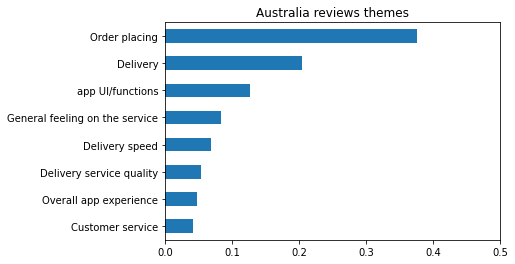

In [66]:
au_topic_weights['dominant_topic_label'].value_counts(normalize=True, ascending=True).plot.barh(title='Australia reviews themes', xlim=(0,0.5))

  0%|          | 0/8 [00:00<?, ?it/s]

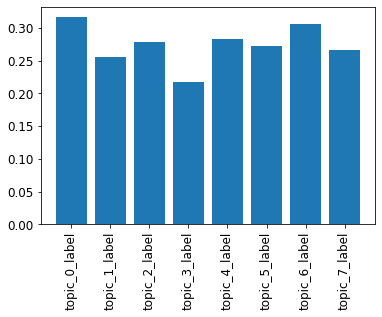

In [67]:
def multiple_labeling(row, col, mean_value):
    if row['dominant_topic_label']==col:
        return True
    elif row[col]>mean_value:
        return True
    else:
        return False
    

for col in tqdm(au_topic_weights.columns[:8]):
    mean_value=au_topic_weights[col].mean()
    au_topic_weights['{}_label'.format(col)]=au_topic_weights.apply(lambda row: multiple_labeling(row, col, mean_value), axis=1)

y_values=[]
total=au_topic_weights.shape[0]
for col in au_topic_weights.columns[-8:]:
    y_values.append(au_topic_weights[col].value_counts().loc[True]/total)
plt.bar(au_topic_weights.columns[-8:], y_values)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12 )
plt.show()